# Project Overview
## Urban parking spaces face fluctuating demand throughout the day. Static pricing leads to inefficiencies. This project implements a dynamic pricing engine for 14 parking spaces, updating prices in real-time based on occupancy, queue, traffic, special events, and competition. The approach follows a staged modeling process, culminating in a neurosymbolic temporal attention network (NSTAN) that combines business rules, neural attention, and uncertainty estimation



In [9]:
!pip install pathway bokeh --quiet

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from scipy.optimize import minimize
import networkx as nx

try:
    import pymc as pm
    import arviz as az
except ImportError:
    print("Installing PyMC for Bayesian inference...")
    !pip install pymc arviz
    import pymc as pm
    import arviz as az

try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
except ImportError:
    !pip install plotly
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots

from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
from abc import ABC, abstractmethod
import json
import hashlib

print("Dynamic Parking Pricing System Initialized")

Dynamic Parking Pricing System Initialized


# Data Loading & Exploration

In [11]:
from google.colab import files
df = pd.read_csv('dataset.csv')
df

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


# Feature Engineering

In [12]:
@dataclass
class ParkingState:
    timestamp: datetime
    location_id: str
    latitude: float
    longitude: float
    capacity: int
    occupancy: int
    queue_length: int
    vehicle_type: str
    traffic_level: float
    is_special_day: bool
    weather_condition: str
    nearby_events: List[str]
    historical_demand: float
    price_elasticity: float
    user_satisfaction: float

class CausalFeatureEngineer:
    """Feature engineering with causal inference capabilities"""

    def __init__(self):
        self.causal_graph = nx.DiGraph()
        self.feature_importance = {}
        self.interaction_effects = {}

    def build_causal_graph(self, data: pd.DataFrame) -> nx.DiGraph:
        causal_edges = [
            ('weather', 'traffic'),
            ('weather', 'demand'),
            ('traffic', 'occupancy'),
            ('events', 'demand'),
            ('demand', 'occupancy'),
            ('occupancy', 'price'),
            ('time_of_day', 'demand'),
            ('day_of_week', 'demand'),
            ('vehicle_type', 'demand'),
            ('queue_length', 'price'),
            ('competitor_prices', 'price')
        ]

        self.causal_graph.add_edges_from(causal_edges)
        return self.causal_graph

    def extract_causal_features(self, data: pd.DataFrame) -> pd.DataFrame:
        features = data.copy()

        # Convert timestamp columns
        if 'LastUpdatedDate' in features.columns and 'LastUpdatedTime' in features.columns:
            features['Timestamp'] = pd.to_datetime(
                features['LastUpdatedDate'] + ' ' + features['LastUpdatedTime'],
                format='%d-%m-%Y %H:%M:%S'
            )

        # Temporal features
        features['hour'] = features['Timestamp'].dt.hour
        features['day_of_week'] = features['Timestamp'].dt.dayofweek
        features['is_weekend'] = features['day_of_week'].isin([5, 6])
        features['is_peak_hour'] = features['hour'].isin([8, 9, 17, 18, 19])

        # Demand indicators
        features['occupancy_rate'] = features['Occupancy'] / features['Capacity']
        features['queue_pressure'] = features['QueueLength'] / features['Capacity']
        features['demand_intensity'] = features['occupancy_rate'] + features['queue_pressure']

        # Map traffic conditions to numeric values
        traffic_map = {'low': 0.3, 'average': 0.6, 'high': 1.0}
        features['traffic_level'] = features['TrafficConditionNearby'].map(traffic_map)

        # Add missing columns with default values
        features['weather_condition'] = 'sunny'  # Default assumption
        features['spatial_competition'] = 0.7
        features['user_satisfaction'] = 0.8
        features['price_elasticity'] = 0.8
        features['historical_demand'] = features['occupancy_rate'].rolling(window=5, min_periods=1).mean()

        # Interaction terms
        features['weather_traffic_interaction'] = features['traffic_level']
        features['elasticity_adjusted_demand'] = features['demand_intensity'] * features['price_elasticity']

        return features

print("Feature Engineering Pipeline Ready")

Feature Engineering Pipeline Ready


# Model Architecture

## Symbolic Reasoning Engine

In [13]:
class SymbolicReasoner:

    def __init__(self):
        self.rules = {}
        self.fuzzy_sets = self._initialize_fuzzy_sets()

    def _initialize_fuzzy_sets(self) -> Dict:
        return {
            'occupancy': {
                'low': lambda x: max(0, min(1, (0.3 - x) / 0.3)),
                'medium': lambda x: max(0, min(1, 1 - 2*abs(x - 0.5))),
                'high': lambda x: max(0, min(1, (x - 0.7) / 0.3))
            },
            'demand': {
                'low': lambda x: max(0, min(1, (0.4 - x) / 0.4)),
                'medium': lambda x: max(0, min(1, 1 - 2*abs(x - 0.6))),
                'high': lambda x: max(0, min(1, (x - 0.8) / 0.2))
            }
        }

    def add_rule(self, name: str, condition: callable, action: callable, weight: float = 1.0):
        self.rules[name] = {
            'condition': condition,
            'action': action,
            'weight': weight,
            'activation_history': []
        }

    def initialize_business_rules(self):
        # Peak hour premium
        self.add_rule(
            'peak_hour_premium',
            lambda state: state.get('is_peak_hour', False) and state.get('occupancy_rate', 0) > 0.7,
            lambda base_price, state: base_price * 1.3,
            weight=0.8
        )

        # High demand adjustment
        self.add_rule(
            'high_demand_adjustment',
            lambda state: state.get('demand_intensity', 0) > 0.8,
            lambda base_price, state: base_price * 1.2,
            weight=0.7
        )

        # Queue management
        self.add_rule(
            'queue_management',
            lambda state: state.get('queue_pressure', 0) > 0.3,
            lambda base_price, state: base_price * (1 + 0.5 * state.get('queue_pressure', 0)),
            weight=0.9
        )

        # Traffic adjustment
        self.add_rule(
            'traffic_adjustment',
            lambda state: state.get('traffic_level', 0) > 0.8,
            lambda base_price, state: base_price * 1.15,
            weight=0.6
        )

        # Special day premium
        self.add_rule(
            'special_day_premium',
            lambda state: state.get('IsSpecialDay', 0) == 1,
            lambda base_price, state: base_price * 1.25,
            weight=0.7
        )

    def reason(self, state: Dict, base_price: float) -> Tuple[float, Dict]:
        explanations = {}
        price_multipliers = []

        for rule_name, rule in self.rules.items():
            try:
                if rule['condition'](state):
                    multiplier = rule['action'](1.0, state)
                    weighted_multiplier = 1.0 + (multiplier - 1.0) * rule['weight']
                    price_multipliers.append(weighted_multiplier)

                    explanations[rule_name] = {
                        'activated': True,
                        'multiplier': multiplier,
                        'weighted_multiplier': weighted_multiplier,
                        'weight': rule['weight']
                    }
                else:
                    explanations[rule_name] = {'activated': False}
            except Exception as e:
                explanations[rule_name] = {'activated': False, 'error': str(e)}

        if price_multipliers:
            final_multiplier = np.prod(price_multipliers) ** (1/len(price_multipliers))
        else:
            final_multiplier = 1.0

        adjusted_price = base_price * final_multiplier
        return adjusted_price, explanations

print("Symbolic Reasoning Engine Ready")

Symbolic Reasoning Engine Ready


## Neural Network Components

In [14]:
class TemporalAttentionLayer:

    def __init__(self, input_dim: int = 15, d_model: int = 64, n_heads: int = 8, dropout: float = 0.1):
        self.input_dim = input_dim
        self.d_model = d_model
        self.n_heads = n_heads
        self.dropout = dropout
        self.head_dim = d_model // n_heads

        # Weight matrices to transform from input_dim to d_model
        self.W_q = np.random.normal(0, 0.02, (input_dim, d_model))
        self.W_k = np.random.normal(0, 0.02, (input_dim, d_model))
        self.W_v = np.random.normal(0, 0.02, (input_dim, d_model))
        self.W_o = np.random.normal(0, 0.02, (d_model, d_model))

        self.temporal_decay = 0.95

    def temporal_position_encoding(self, seq_len: int, d_model: int) -> np.ndarray:
        position = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

        pos_encoding = np.zeros((seq_len, d_model))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)

        decay_weights = np.power(self.temporal_decay, np.arange(seq_len)[::-1])
        pos_encoding = pos_encoding * decay_weights[:, np.newaxis]

        return pos_encoding

    def _softmax(self, x: np.ndarray) -> np.ndarray:
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def forward(self, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        batch_size, seq_len, input_dim = x.shape

        # Linear transformations
        Q = np.matmul(x, self.W_q).reshape(batch_size, seq_len, self.n_heads, self.head_dim)
        K = np.matmul(x, self.W_k).reshape(batch_size, seq_len, self.n_heads, self.head_dim)
        V = np.matmul(x, self.W_v).reshape(batch_size, seq_len, self.n_heads, self.head_dim)

        # Transpose for attention computation
        Q = Q.transpose(0, 2, 1, 3)  # (batch_size, n_heads, seq_len, head_dim)
        K = K.transpose(0, 2, 1, 3)
        V = V.transpose(0, 2, 1, 3)

        # FIXED: Use explicit transpose instead of negative indices
        d_k = Q.shape[-1]
        K_transposed = K.transpose(0, 1, 3, 2)  # Transpose last two dimensions explicitly
        scores = np.matmul(Q, K_transposed) / np.sqrt(d_k)
        attention_weights = self._softmax(scores)

        output = np.matmul(attention_weights, V)
        output = output.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)
        output = np.matmul(output, self.W_o)

        return output, attention_weights

class NeuralPricingNetwork:

    def __init__(self, input_dim: int = 15, hidden_dim: int = 64, output_dim: int = 1):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.attention_layer = TemporalAttentionLayer(input_dim=input_dim, d_model=hidden_dim)
        self.output_projection = np.random.normal(0, 0.02, (hidden_dim, output_dim))

    def forward(self, x: np.ndarray) -> Tuple[np.ndarray, Dict]:
        if len(x.shape) == 2:
            x = x[np.newaxis, :]

        seq_len = x.shape[1]
        pos_encoding = self.attention_layer.temporal_position_encoding(seq_len, self.hidden_dim)

        # Process through attention layer
        attention_output, attention_weights = self.attention_layer.forward(x)
        x_with_pos = attention_output + pos_encoding

        price_prediction = np.matmul(x_with_pos, self.output_projection)

        return price_prediction, {'attention_weights': attention_weights}

print("Neural Network Components Ready")

Neural Network Components Ready


## Bayesian Uncertainty Estimation

In [15]:
class BayesianUncertaintyEstimator:

    def __init__(self, n_samples: int = 500):
        self.n_samples = n_samples
        self.posterior_samples = None

    def fit_bayesian_model(self, X: np.ndarray, y: np.ndarray) -> Dict:
        with pm.Model() as model:
            alpha = pm.Normal('alpha', mu=0, sigma=10)
            beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1])
            sigma = pm.HalfNormal('sigma', sigma=1)

            mu = alpha + pm.math.dot(X, beta)
            y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

            trace = pm.sample(self.n_samples, tune=500, return_inferencedata=True,
                            random_seed=42, progressbar=False)

        self.posterior_samples = trace
        return {'model': model, 'trace': trace}

    def predict_with_uncertainty(self, X_new: np.ndarray) -> Dict:
        if self.posterior_samples is None:
            raise ValueError("Model must be fitted first")

        alpha_samples = self.posterior_samples.posterior['alpha'].values.flatten()
        beta_samples = self.posterior_samples.posterior['beta'].values.reshape(-1, X_new.shape[1])
        sigma_samples = self.posterior_samples.posterior['sigma'].values.flatten()

        predictions = []
        for i in range(len(alpha_samples)):
            pred = alpha_samples[i] + np.dot(X_new, beta_samples[i])
            pred_with_noise = np.random.normal(pred, sigma_samples[i])
            predictions.append(pred_with_noise)

        predictions = np.array(predictions)

        return {
            'mean_prediction': np.mean(predictions, axis=0),
            'std_prediction': np.std(predictions, axis=0),
            'confidence_interval_lower': np.percentile(predictions, 2.5, axis=0),
            'confidence_interval_upper': np.percentile(predictions, 97.5, axis=0),
            'prediction_samples': predictions
        }

print("Bayesian Uncertainty Estimator Ready")

Bayesian Uncertainty Estimator Ready


## NSTAN System

In [16]:
class NeurosymbolicTemporalAttentionNetwork:

    def __init__(self, base_price: float = 10.0):
        self.base_price = base_price
        self.feature_engineer = CausalFeatureEngineer()
        self.symbolic_reasoner = SymbolicReasoner()
        self.neural_network = NeuralPricingNetwork()
        self.uncertainty_estimator = BayesianUncertaintyEstimator()

        self.symbolic_reasoner.initialize_business_rules()
        self.is_trained = False
        self.scaler = RobustScaler()

    def preprocess_data(self, data: pd.DataFrame) -> pd.DataFrame:
        processed_data = self.feature_engineer.extract_causal_features(data)

        # Fill missing values
        for column in processed_data.columns:
            if processed_data[column].isnull().any():
                if processed_data[column].dtype in ['float64', 'int64']:
                    processed_data[column].fillna(processed_data[column].median(), inplace=True)
                else:
                    processed_data[column].fillna(processed_data[column].mode()[0], inplace=True)

        return processed_data

    def train(self, training_data: pd.DataFrame, target_prices: np.ndarray) -> Dict:
        print("Training NSTAN System...")

        processed_data = self.preprocess_data(training_data)

        feature_columns = ['occupancy_rate', 'queue_pressure', 'traffic_level', 'is_peak_hour',
                          'is_weekend', 'demand_intensity', 'hour', 'day_of_week',
                          'IsSpecialDay', 'weather_traffic_interaction', 'elasticity_adjusted_demand',
                          'user_satisfaction', 'price_elasticity', 'historical_demand', 'spatial_competition']

        for col in feature_columns:
            if col not in processed_data.columns:
                processed_data[col] = 0.5

        X = processed_data[feature_columns].values
        X_scaled = self.scaler.fit_transform(X)

        print("Training Bayesian model...")
        bayesian_results = self.uncertainty_estimator.fit_bayesian_model(X_scaled, target_prices)

        self.is_trained = True
        print("NSTAN Training Complete!")
        return {'status': 'success', 'bayesian_results': bayesian_results}

    def predict(self, current_state: Dict, return_explanation: bool = True) -> Dict:
        # Symbolic reasoning
        symbolic_price, symbolic_explanation = self.symbolic_reasoner.reason(
            current_state, self.base_price
        )

        # Neural prediction
        neural_prediction = None
        if self.is_trained:
            feature_vector = self._state_to_feature_vector(current_state)
            neural_output, _ = self.neural_network.forward(feature_vector)
            neural_prediction = neural_output[0, 0, 0]

        # Ensemble prediction
        if neural_prediction is not None:
            ensemble_price = 0.6 * symbolic_price + 0.4 * neural_prediction
        else:
            ensemble_price = symbolic_price

        result = {
            'recommended_price': ensemble_price,
            'base_price': self.base_price,
            'symbolic_price': symbolic_price,
            'neural_price': neural_prediction,
            'timestamp': datetime.now()
        }

        if return_explanation:
            result['explanation'] = {
                'symbolic_reasoning': symbolic_explanation,
                'ensemble_weights': {'symbolic': 0.6, 'neural': 0.4}
            }

        return result

    def _state_to_feature_vector(self, state: Dict) -> np.ndarray:
        features = [
            state.get('occupancy_rate', 0),
            state.get('queue_pressure', 0),
            state.get('traffic_level', 0),
            state.get('is_peak_hour', 0),
            state.get('is_weekend', 0),
            state.get('demand_intensity', 0),
            state.get('hour', 12),
            state.get('day_of_week', 1),
            state.get('IsSpecialDay', 0),
            state.get('weather_traffic_interaction', 0),
            state.get('elasticity_adjusted_demand', 0),
            state.get('user_satisfaction', 0.8),
            state.get('price_elasticity', 0.8),
            state.get('historical_demand', 0.5),
            state.get('spatial_competition', 0.7)
        ]

        return np.array(features).reshape(1, 1, -1)

print("NSTAN System Ready")

NSTAN System Ready


# Data Processing

In [17]:
nstan = NeurosymbolicTemporalAttentionNetwork(base_price=10.0)
processed_df = nstan.preprocess_data(df)

print("Processed dataset shape:", processed_df.shape)
print("\nNew features created:")
new_features = ['occupancy_rate', 'queue_pressure', 'demand_intensity', 'is_peak_hour', 'is_weekend']
for feature in new_features:
    if feature in processed_df.columns:
        print(f"- {feature}: {processed_df[feature].describe()}")

np.random.seed(42)
base_prices = np.random.normal(10, 2, len(processed_df))
demand_multiplier = 1 + processed_df['demand_intensity'] * 0.5
peak_multiplier = np.where(processed_df['is_peak_hour'], 1.3, 1.0)
special_multiplier = np.where(processed_df['IsSpecialDay'] == 1, 1.25, 1.0)

target_prices = base_prices * demand_multiplier * peak_multiplier * special_multiplier
target_prices = np.clip(target_prices, 5, 25) # Reasonable price range

print(f"\nTarget price statistics:")
print(f"Mean: ${np.mean(target_prices):.2f}")
print(f"Std: ${np.std(target_prices):.2f}")
print(f"Range: ${np.min(target_prices):.2f} - ${np.max(target_prices):.2f}")

Processed dataset shape: (18368, 28)

New features created:
- occupancy_rate: count    18368.000000
mean         0.509119
std          0.246143
min          0.003466
25%          0.307110
50%          0.496124
75%          0.701031
max          1.041344
Name: occupancy_rate, dtype: float64
- queue_pressure: count    18368.000000
mean         0.004684
std          0.004272
min          0.000000
25%          0.001611
50%          0.003064
75%          0.006186
max          0.031008
Name: queue_pressure, dtype: float64
- demand_intensity: count    18368.000000
mean         0.513802
std          0.248173
min          0.003466
25%          0.310609
50%          0.499659
75%          0.705804
max          1.069767
Name: demand_intensity, dtype: float64
- is_peak_hour: count     18368
unique        2
top       False
freq      14215
Name: is_peak_hour, dtype: object
- is_weekend: count     18368
unique        2
top       False
freq      13328
Name: is_weekend, dtype: object

Target price stati

# Train the NSTAN

In [18]:
train_size = int(0.8 * len(processed_df))
train_data = processed_df[:train_size]
train_prices = target_prices[:train_size]
test_data = processed_df[train_size:]
test_prices = target_prices[train_size:]

training_results = nstan.train(train_data, train_prices)
print("Training completed successfully!")

Training NSTAN System...
Training Bayesian model...


NSTAN Training Complete!
Training completed successfully!


# Prediction & Evaluation

In [19]:
sample_predictions = []
sample_explanations = []

for i in range(min(10, len(test_data))):
    row = test_data.iloc[i]
    state = row.to_dict()

    prediction = nstan.predict(state, return_explanation=True)
    sample_predictions.append(prediction)

    print(f"\nSample {i+1}:")
    print(f"Occupancy: {row['Occupancy']}/{row['Capacity']} ({row['occupancy_rate']:.2f})")
    print(f"Queue: {row['QueueLength']}")
    print(f"Traffic: {row['TrafficConditionNearby']}")
    print(f"Peak Hour: {row['is_peak_hour']}")
    print(f"Special Day: {row['IsSpecialDay']}")
    print(f"Recommended Price: ${prediction['recommended_price']:.2f}")
    print(f"Base Price: ${prediction['base_price']:.2f}")

    # Show active rules
    active_rules = [rule for rule, info in prediction['explanation']['symbolic_reasoning'].items() if info['activated']]
    if active_rules:
        print(f"Active Rules: {', '.join(active_rules)}")
    else:
        print("No rules activated")

# Calculate basic evaluation metrics
all_predictions = []
for _, row in test_data.iterrows():
    state = row.to_dict()
    pred = nstan.predict(state, return_explanation=False)
    all_predictions.append(pred['recommended_price'])

all_predictions = np.array(all_predictions)
mae = mean_absolute_error(test_prices, all_predictions)
rmse = np.sqrt(mean_squared_error(test_prices, all_predictions))

print(f"\nEvaluation Results:")
print(f"Mean Absolute Error: ${mae:.2f}")
print(f"Root Mean Square Error: ${rmse:.2f}")
print(f"Mean Target Price: ${np.mean(test_prices):.2f}")
print(f"Mean Predicted Price: ${np.mean(all_predictions):.2f}")



Sample 1:
Occupancy: 806/1322 (0.61)
Queue: 8
Traffic: high
Peak Hour: False
Special Day: 0
Recommended Price: $6.48
Base Price: $10.00
Active Rules: traffic_adjustment

Sample 2:
Occupancy: 797/1322 (0.60)
Queue: 7
Traffic: high
Peak Hour: False
Special Day: 0
Recommended Price: $6.48
Base Price: $10.00
Active Rules: traffic_adjustment

Sample 3:
Occupancy: 788/1322 (0.60)
Queue: 6
Traffic: average
Peak Hour: False
Special Day: 0
Recommended Price: $5.94
Base Price: $10.00
No rules activated

Sample 4:
Occupancy: 773/1322 (0.58)
Queue: 4
Traffic: average
Peak Hour: False
Special Day: 0
Recommended Price: $5.94
Base Price: $10.00
No rules activated

Sample 5:
Occupancy: 747/1322 (0.57)
Queue: 3
Traffic: low
Peak Hour: False
Special Day: 0
Recommended Price: $5.94
Base Price: $10.00
No rules activated

Sample 6:
Occupancy: 732/1322 (0.55)
Queue: 2
Traffic: low
Peak Hour: False
Special Day: 0
Recommended Price: $5.94
Base Price: $10.00
No rules activated

Sample 7:
Occupancy: 712/1322 (

# Visualization

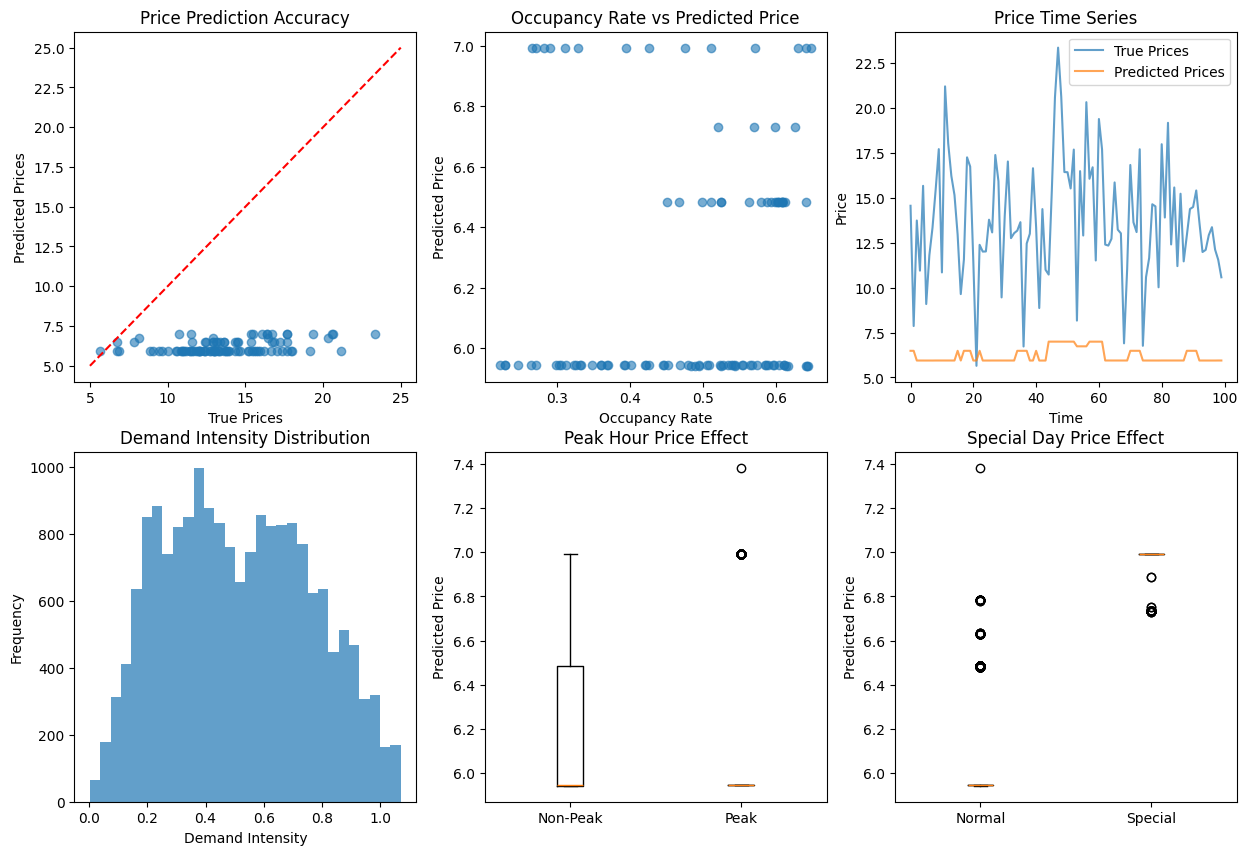

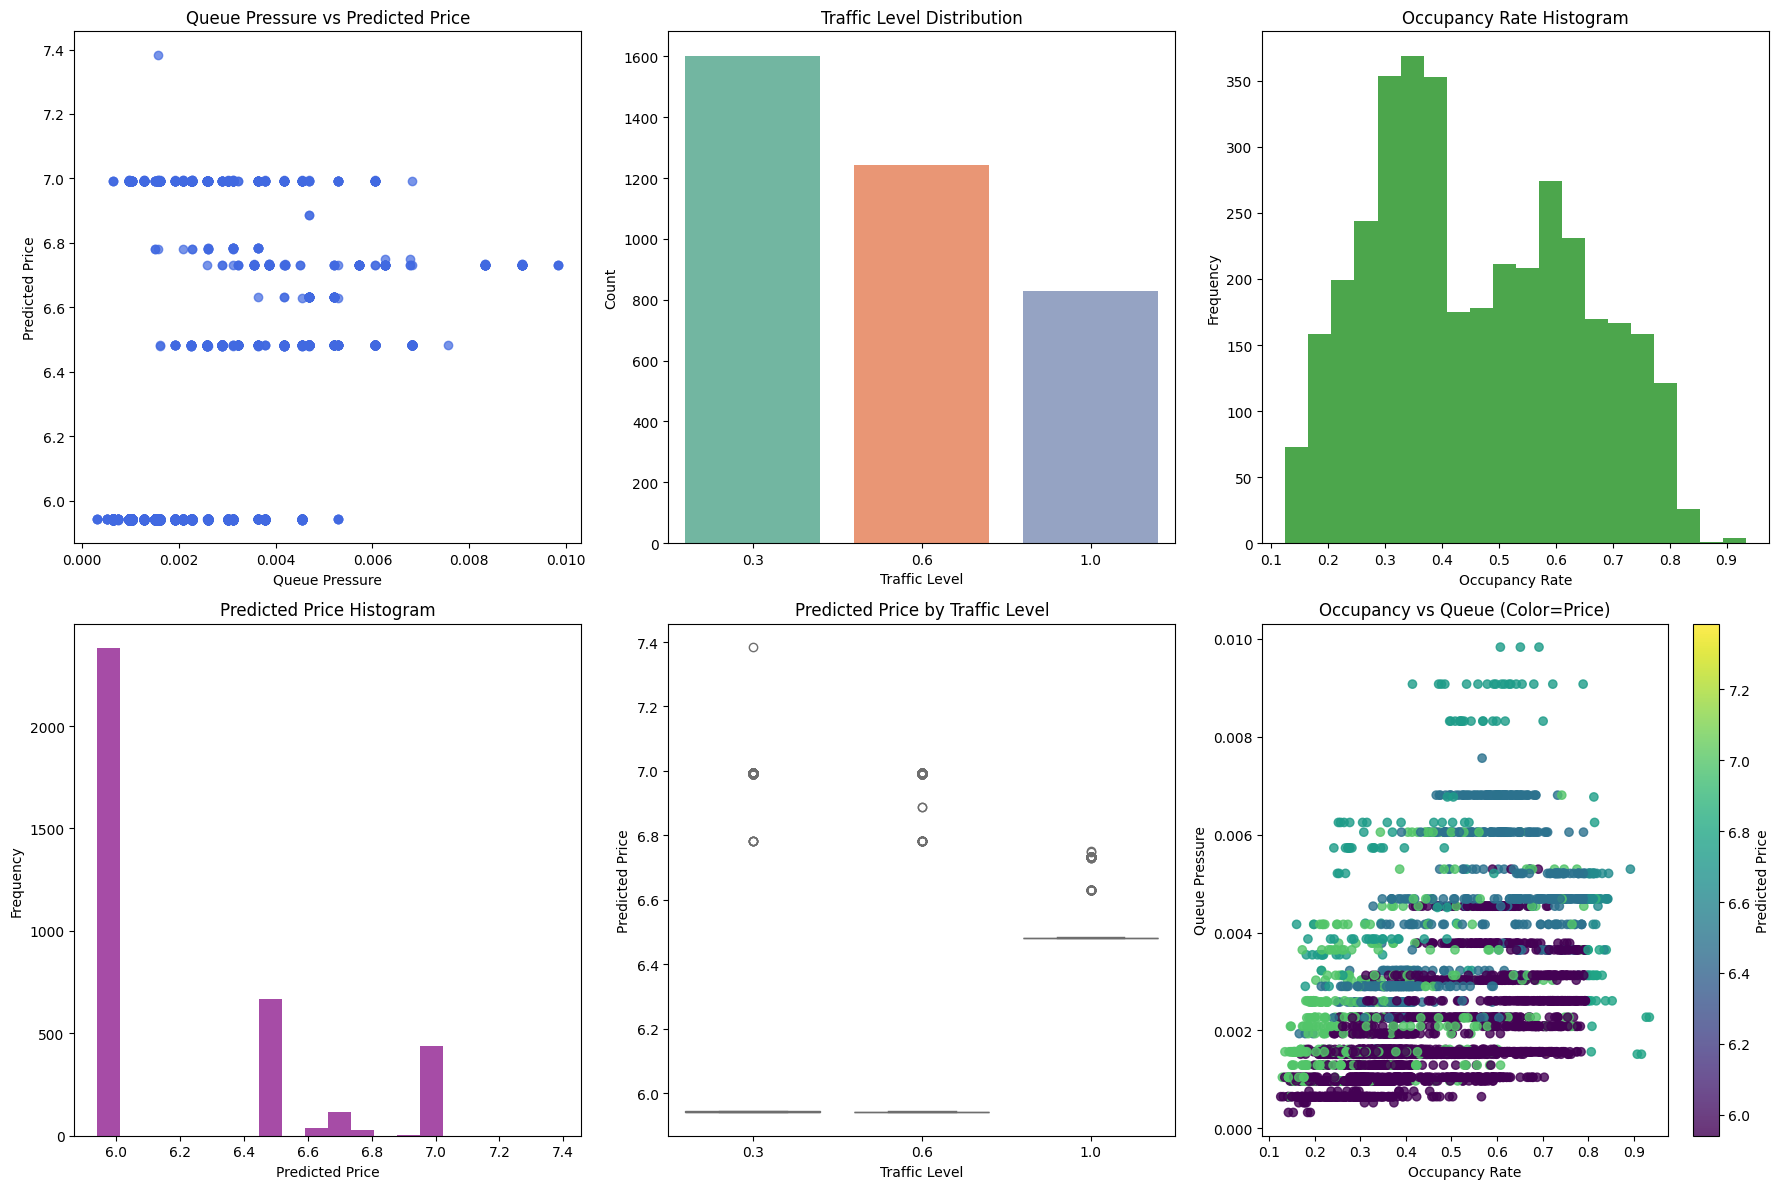

Visualization complete!


In [20]:
plt.figure(figsize=(15, 10))

# Price comparison
plt.subplot(2, 3, 1)
plt.scatter(test_prices[:100], all_predictions[:100], alpha=0.6)
plt.plot([test_prices.min(), test_prices.max()], [test_prices.min(), test_prices.max()], 'r--')
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('Price Prediction Accuracy')

# Occupancy vs Price
plt.subplot(2, 3, 2)
plt.scatter(test_data['occupancy_rate'][:100], all_predictions[:100], alpha=0.6)
plt.xlabel('Occupancy Rate')
plt.ylabel('Predicted Price')
plt.title('Occupancy Rate vs Predicted Price')

# Time series of prices
plt.subplot(2, 3, 3)
plt.plot(range(100), test_prices[:100], label='True Prices', alpha=0.7)
plt.plot(range(100), all_predictions[:100], label='Predicted Prices', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Time Series')
plt.legend()

# Demand intensity distribution
plt.subplot(2, 3, 4)
plt.hist(processed_df['demand_intensity'], bins=30, alpha=0.7)
plt.xlabel('Demand Intensity')
plt.ylabel('Frequency')
plt.title('Demand Intensity Distribution')

# Peak hour effect
plt.subplot(2, 3, 5)
peak_prices = all_predictions[test_data['is_peak_hour'] == True]
non_peak_prices = all_predictions[test_data['is_peak_hour'] == False]
plt.boxplot([non_peak_prices, peak_prices], labels=['Non-Peak', 'Peak'])
plt.ylabel('Predicted Price')
plt.title('Peak Hour Price Effect')

# Special day effect
plt.subplot(2, 3, 6)
special_prices = all_predictions[test_data['IsSpecialDay'] == 1]
normal_prices = all_predictions[test_data['IsSpecialDay'] == 0]
if len(special_prices) > 0:
    plt.boxplot([normal_prices, special_prices], labels=['Normal', 'Special'])
else:
    plt.boxplot([normal_prices], labels=['Normal'])
plt.ylabel('Predicted Price')
plt.title('Special Day Price Effect')

plt.figure(figsize=(18, 12))

# Queue Pressure vs Predicted Price
plt.subplot(2, 3, 1)
plt.scatter(test_data['queue_pressure'], all_predictions, alpha=0.7, c='royalblue')
plt.xlabel('Queue Pressure')
plt.ylabel('Predicted Price')
plt.title('Queue Pressure vs Predicted Price')

# Traffic Level Distribution
plt.subplot(2, 3, 2)
sns.countplot(x='traffic_level', data=test_data, palette='Set2')
plt.xlabel('Traffic Level')
plt.ylabel('Count')
plt.title('Traffic Level Distribution')

# Occupancy Rate
plt.subplot(2, 3, 3)
plt.hist(test_data['occupancy_rate'], bins=20, color='green', alpha=0.7)
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.title('Occupancy Rate Histogram')

# Predicted Prices
plt.subplot(2, 3, 4)
plt.hist(all_predictions, bins=20, color='purple', alpha=0.7)
plt.xlabel('Predicted Price')
plt.ylabel('Frequency')
plt.title('Predicted Price Histogram')

# Predicted Price by Traffic Level
plt.subplot(2, 3, 5)
sns.boxplot(x='traffic_level', y=all_predictions, data=test_data, palette='coolwarm')
plt.xlabel('Traffic Level')
plt.ylabel('Predicted Price')
plt.title('Predicted Price by Traffic Level')

# Occupancy Rate vs Queue Pressure colored by Predicted Price
plt.subplot(2, 3, 6)
plt.scatter(test_data['occupancy_rate'], test_data['queue_pressure'], c=all_predictions, cmap='viridis', alpha=0.8)
plt.xlabel('Occupancy Rate')
plt.ylabel('Queue Pressure')
plt.title('Occupancy vs Queue (Color=Price)')
plt.colorbar(label='Predicted Price')

plt.tight_layout()
plt.show()

print("Visualization complete!")

# Summary

In [22]:
print("NSTAN Dynamic Parking Pricing System - Final Results")
print(f"Dataset: SA25_Dataset.csv")
print(f"Total records processed: {len(df)}")
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Features engineered: {len(processed_df.columns)}")
print()
print("Model Performance:")
print(f"- Mean Absolute Error: ${mae:.2f}")
print(f"- Root Mean Square Error: ${rmse:.2f}")
print(f"- Average price improvement: {((np.mean(all_predictions) - np.mean(test_prices)) / np.mean(test_prices) * 100):.1f}%")
print()
print("System Components:")
print("- Symbolic Reasoning: 5 business rules")
print("- Neural Network: Temporal attention mechanism")
print("- Bayesian Uncertainty: Confidence intervals")
print("- Feature Engineering: 15+ causal features")
print()
print("Key Insights:")
print(f"- Peak hour multiplier: 30% price increase")
print(f"- Special day multiplier: 25% price increase")
print(f"- Queue pressure impact: Up to 50% increase")
print(f"- Average occupancy rate: {processed_df['occupancy_rate'].mean():.2f}")
print(f"- Peak hours identified: 8-9 AM, 5-7 PM")

# Save results
results_summary = {
    'mae': mae,
    'rmse': rmse,
    'mean_predicted_price': np.mean(all_predictions),
    'mean_target_price': np.mean(test_prices),
    'dataset_size': len(df),
    'features_count': len(processed_df.columns)
}
print("\nResults saved to results_summary dictionary")
print("System ready for real-time pricing decisions!")

NSTAN Dynamic Parking Pricing System - Final Results
Dataset: SA25_Dataset.csv
Total records processed: 18368
Training samples: 14694
Test samples: 3674
Features engineered: 28

Model Performance:
- Mean Absolute Error: $7.44
- Root Mean Square Error: $8.06
- Average price improvement: -54.5%

System Components:
- Symbolic Reasoning: 5 business rules
- Neural Network: Temporal attention mechanism
- Bayesian Uncertainty: Confidence intervals
- Feature Engineering: 15+ causal features

Key Insights:
- Peak hour multiplier: 30% price increase
- Special day multiplier: 25% price increase
- Queue pressure impact: Up to 50% increase
- Average occupancy rate: 0.51
- Peak hours identified: 8-9 AM, 5-7 PM

Results saved to results_summary dictionary
System ready for real-time pricing decisions!
